In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn import model_selection

import sys

#load mnist datasets
mnist = datasets.fetch_mldata("MNIST original", data_home=".")

In [2]:
#input data & label preprocessing
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(mnist.data, mnist.target, test_size = 1/7)

X_train = X_train / 255.
X_test = X_test/ 255.

#add bias
b_train = np.ones((len(X_train), 1))
b_test = np.ones((len(X_test), 1))
X_train = np.append(X_train, b_train, axis = 1)
X_test = np.append(X_test, b_test, axis = 1)

#convert to one-hot label
Y_train = [[0 if i != y_train[j] else 1 for i in range(10)] for j in range(len(y_train))]
Y_test = [[0 if i != y_test[j] else 1 for i in range(10)] for j in range(len(y_test))]
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [3]:
#weight init (-1 ~ 1)
weight = (1.0 - (-1.0)) * np.random.rand(3, 28*28+1, 28*28+1) -1

#define learning rate
lr = 0.001

#define mu for momentum
mu = 0.8

#define alpha, g for RMSProp
alpha = 0.9
g = np.zeros((3, 28*28+1, 28*28+1))

#define epoch
epoch = 20

#define batch size
batch_size = 200

In [4]:
#fully connected layer
def myFCLayer(output_unit, input_data, layer_no):
    w = weight[layer_no, 0:output_unit, 0:len(input_data)]
    z = np.dot(w, input_data)

    return z

In [5]:
#activation
def myActivation(z, activation):
    if activation == "ReLU":
        y = myReLU(z)
        
    elif activation == "softmax":
        y = mySoftmax(len(z), z)
        
    return y

In [6]:
#activation function - ReLU
def myReLU(z):
    y = np.where(z > 0, z, 0)
    
    return y

#activation function - softmax function
def mySoftmax(unit_no, input_data):
    m = np.max(input_data)
    ei = np.exp(input_data - m)
    s = np.sum(ei)
    y = ei / s
    
    return y

In [7]:
#drop out layer
def myDropOut(input_data, late):
    index = np.random.randint(0, int(len(input_data) * late))
    domask = np.ones(len(input_data))
    domask[index] = 0
    
    return domask


In [8]:
#calculate accuracy
def myCalcAcc(est, label_data):
    est = np.array(est)
    label_data = np.array(label_data)
    
    a = np.argmax(est, axis=1) - np.argmax(label_data, axis=1)
    acc = np.sum(a == 0)
    acc = acc / label_data.shape[0]
    
    return acc

In [9]:
#loss function - Cross Entropy
def myCrossEntropy(est, t):
    E = 0
    for i in range(len(t)):
        Ei = 0
        for j in range(len(t[0])):
            Ei -= t[i][j] * np.log(est[i][j] + 1e-8)
        E += Ei
    
    return E

In [10]:
#calculate δ for CrossEntropy + SoftMax
def myCalcDeltaOut(est, label_data):
    d = est - label_data
    
    return d

def myCalcDelta(delta, step, z):
    z = np.array(z)
    
    wd = np.dot(delta, weight[-step, 0:len(delta[0]), 0:len(z[0])])
    fz = np.where(z > 0, 1, 0)
    d = wd * fz
    
    return d

In [11]:
def myCalcDE(delta, x):
    DE = np.empty((0, len(x[0])))
    for i in range(len(delta[0])):
        nw = np.array([np.dot(delta[:,i], x)])
        DE = np.append(DE, nw, axis=0)

    return DE

In [12]:
#RMSprop
def myWeightUpdate_RMSProp(DE, layer_no):
    for i in range(len(DE)):
        g_t = g[layer_no - 1, 0:len(DE), 0:len(DE[0])]
        w = weight[layer_no - 1, 0:len(DE), 0:len(DE[0])]
        
        g_t[i] = (alpha * g_t[i]) + (1 - alpha) * (DE[i] ** 2)
        w[i] -= (lr / (np.sqrt(g_t[i]) + 1e-8)) * DE[i]
        
        g[layer_no -1, 0:len(DE), 0:len(DE[0])] = g_t
        weight[layer_no - 1, 0:len(DE), 0:len(DE[0])] = w

In [13]:
#Get Mini Batch
def myGetBatch(X, Y, size):
    Y = np.array(Y)
    rnd_index = np.arange(X.shape[0])
    np.random.shuffle(rnd_index)
    X_shuf = X[rnd_index, :]
    Y_shuf = Y[rnd_index, :]
    
    for i in range(0, X.shape[0], size):
        X_batch = X_shuf[i : i + size]
        Y_batch = Y_shuf[i : i + size]
        
        yield X_batch, Y_batch

In [14]:
#main
t_loss = []
test_acc_list = []
test_loss_list = []

for ep in range(epoch):
    train_acc = 0
    train_E = 0
    cnt = 0
  
    #training
    for X_batch, Y_batch in myGetBatch(X_train, Y_train, batch_size):
        est = []
        z1list = []
        x2list = []
        z2list = []
        x3list = []
        z3list = []
        domask1 = []
        domask2 = []
        
        for x1 in X_batch:
            #FC1
            z1 = myFCLayer(512, x1, 0)
            z1 = np.append(z1, 1)           #add bias
            z1list.append(z1)
            x2 = myActivation(z1, "ReLU")
            
            #DO1
            dm1 = myDropOut(x2, 0.2)
            domask1.append(dm1)
            x2 *= dm1
            x2list.append(x2)
            
            #FC2
            z2 = myFCLayer(512, x2, 1)
            z2 = np.append(z2, 1)           #add bias
            z2list.append(z2)
            x3 = myActivation(z2, "ReLU")
            
            #DO2
            dm2 = myDropOut(x3, 0.2)
            domask2.append(dm2)
            x3 *= dm2
            x3list.append(x3)
            
            #FC3
            z3 = myFCLayer(10, x3, 2)
            z3list.append(z3)
            z3 = np.array(z3)
            y = myActivation(z3, "softmax")
            est.append(y)
        
        train_acc += myCalcAcc(est, Y_batch)            
        train_E += myCrossEntropy(est, Y_batch)
        
        #back propagation
        d3 = myCalcDeltaOut(est, Y_batch)
        d2 = myCalcDelta(d3, 1, z2list)
        d1 = myCalcDelta(d2, 2, z1list)
        
        DE3 = myCalcDE(d3, x3list)
        DE2 = myCalcDE(d2, x2list)
        DE1 = myCalcDE(d1, X_batch)
        
        myWeightUpdate_RMSProp(DE3, 3)
        myWeightUpdate_RMSProp(DE2, 2)
        myWeightUpdate_RMSProp(DE1, 1)
        
        cnt += len(X_batch)
        sys.stdout.write("\repoch[%d/%d] %d/%d" % (ep + 1, epoch, cnt, len(X_train)))
        
    train_acc = train_acc / (X_train.shape[0] / batch_size)
    train_E = train_E / X_train.shape[0]
    
    
    #testing
    test_est = []
    test_z1list = []
    test_x2list = []
    test_z2list = []
    test_x3list = []
    test_z3list = []
    
    for test_x1 in X_test:
        test_z1 = myFCLayer(512, test_x1, 0)
        test_z1 = np.append(test_z1, 1)           #add bias
        test_z1list.append(test_z1)
        test_x2 = myActivation(test_z1, "ReLU")
        test_x2list.append(test_x2)
        
        test_z2 = myFCLayer(512, test_x2, 1)
        test_z2 = np.append(test_z2, 1)           #add bias
        test_z2list.append(test_z2)
        test_x3 = myActivation(test_z2, "ReLU")
        test_x3list.append(test_x3)
        
        test_z3 = myFCLayer(10, test_x3, 2)
        test_z3list.append(test_z3)
        test_z3 = np.array(test_z3)
        test_y = myActivation(test_z3, "softmax")
        test_est.append(test_y)
        
    test_acc = myCalcAcc(test_est, Y_test)
    test_acc_list.append(test_acc)
    test_E = myCrossEntropy(test_est, Y_test) / X_test.shape[0]
    test_loss_list.append(test_E)
        
    print("  train_acc = " + "{0:.8f}".format(train_acc), end = "")
    print("  train_loss = " + "{0:.8f}".format(train_E), end = "")
    print("  test_acc = " + "{0:.8f}".format(test_acc), end = "")
    print("  test_loss = " + "{0:.8f}".format(test_E))

epoch[1/20] 60000/60000  train_acc = 0.81865000  train_loss = 3.19721179  test_acc = 0.90820000  test_loss = 1.59001585
epoch[2/20] 60000/60000  train_acc = 0.92855000  train_loss = 1.21803759  test_acc = 0.93050000  test_loss = 1.18937287
epoch[3/20] 60000/60000  train_acc = 0.95051667  train_loss = 0.82853641  test_acc = 0.93560000  test_loss = 1.09466918
epoch[4/20] 60000/60000  train_acc = 0.96265000  train_loss = 0.61933668  test_acc = 0.94750000  test_loss = 0.87917559
epoch[5/20] 60000/60000  train_acc = 0.97106667  train_loss = 0.47600304  test_acc = 0.95280000  test_loss = 0.80814305
epoch[6/20] 60000/60000  train_acc = 0.97725000  train_loss = 0.36469582  test_acc = 0.94970000  test_loss = 0.85223985
epoch[7/20] 60000/60000  train_acc = 0.98171667  train_loss = 0.28794266  test_acc = 0.95720000  test_loss = 0.73188930
epoch[8/20] 60000/60000  train_acc = 0.98481667  train_loss = 0.23849126  test_acc = 0.95620000  test_loss = 0.75737724
epoch[9/20] 60000/60000  train_acc = 0.9

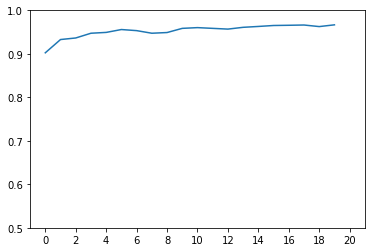

In [25]:
plt.xlim(-1, 21)
plt.ylim(0.5, 1)
tix = np.arange(0,21,2)
tiy = np.arange(0.5,1.09,0.1)
plt.xticks(tix)
plt.yticks(tiy)
plt.plot(range(epoch), test_acc_list)
plt.show()